In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from scipy import constants

In [88]:
#*TC model for yield strength at room temperature
class TC_model:
    def __init__(self, x, f, k, r, r2, r3, delta, mu):
        self.x = x #* atomic concentration
        self.f = f #* packing factor
        self.k = k #* bulk modulus
        self.r = r #* TC-EARS atomic radii
        self.r2 = r2 #* Var-EARS atomic radii
        self.r3 = r3 #* Curtin's atomic radii
        self.delta = delta #* change in composition, 0.001 is used in the paper
        self.mu = mu #* Shear modulus

    def lattice_param(self):
        '''
        Lattice parameter $a$.
        '''
        matrix = self.sij()
        a =  1/self.f*np.dot(np.dot(self.x, matrix), self.x.T)
        return a

    def lattice_param_(self, x_):
        ''' 
        The distorted term within lattice.
        '''
        matrix = self.sij()
        a = np.dot(np.dot(x_, matrix), x_.T)
        return a

    def sij(self):
        ''' 
        Interatomic spacing $s_ij$.
        NxN matrix where N is the number of elements.
        '''
        k, r = self.k, self.r
        len_s = len(self.x[0])
        matrix = np.zeros((len_s, len_s))
        for i in range(len_s):
            for j in range(len_s):
                matrix[i][j] = ((4*(r[i]**2)*k[i]*self.x[0][i] + 4*(r[j]**2)*k[j]*self.x[0][j])/
                                    (2*r[i]*k[i]*self.x[0][i] + 2*r[j]*k[j]*self.x[0][j]))
        # print(matrix)
        return matrix

    def delta_(self, da_x):
        '''  
        Estimated lattice distortion $\delta$.
        '''
        return np.dot(np.dot(self.x, da_x), self.x.T)

    def da_x_(self, i, j):
        ''' 
        Each single da_x
        '''
        dx = self.delta
        x = self.x
        x_ = x.copy()
        x_[0][i] -= dx
        x_[0][j] += dx
        da_x = (self.lattice_param()*self.f - self.lattice_param_(x_))/dx
        return da_x

    #* TD-model for yield strength.
    def ys_(self, s0):
        mu = self.mu
        a = self.lattice_param().flatten()[0]
        len_s = len(self.x[0])
        da_x = np.zeros((len_s, len_s))
        #* Matrix of da_x
        for i in range(len_s):
            for j in range(len_s):
                if i != j:
                    da_x[i][j] = abs(self.da_x_(i, j))**(4/3)
        delta = self.delta_(da_x)
        return s0 + 3*5*mu*((1*16/a)**(4/3))*delta

    def volome_mis(self):

        atom_v3 = (self.r3*math.sqrt(2)*2)**3/4 #* atomic volume by radii from reference
        b3 = np.mean(self.r3)*2
        # print(f'ave_atom by radii from closed packing model: {atom_v3}')
        atom_v2 = (self.r2*math.sqrt(2)*2)**3/4 #* atomic volume by radii from reference
        b2 = np.mean(self.r2)*2
        # print(f'ave_atom by radii from closed packing model: {atom_v2}')
        atom_v = (self.r*math.sqrt(2)*2)**3/4 #* atomic volume by TC model
        b = np.mean(self.r)*2
        # print(f'ave_atom by TC model: {atom_v}')

        ave_atom_v = np.mean(atom_v) #*Mixture vol by average of atoms
        ave_atom_v2  = np.mean(atom_v2)
        ave_atom_v3 = np.mean(atom_v3) #*Mixture vol by average of atoms

        return [atom_v-ave_atom_v, atom_v2-ave_atom_v2, atom_v3-ave_atom_v3,
                b, b2, b3]

    #*deltaE_b
    def dEb(self):
        l_param = self.lattice_param().flatten()[0]
        x = self.x
        # b = math.sqrt(2)/2*l_param
        # print(f'b: {b}')

        # print(f'ave_atom by linear average: {ave_atom_v}')
        # ave_atom_v = l_param**3/4 #* Mixture vol By lattice param calculated
        # print(f'ave_atom by lattice param: {ave_atom_v}')
        diff_v, diff_v2, diff_v3, b, b2, b3 = self.volome_mis()

        sum_x1 = np.sum(x*(diff_v)**2)/b**6
        sum_x2 = np.sum(x*(diff_v2)**2)/b2**6
        sum_x3 = np.sum(x*(diff_v3)**2)/b3**6

        poi_v = np.sum(x[0]*np.array([0.275, 0.293, 0.310]))
        poi_part = ((1+poi_v)/(1-poi_v))**(2/3)

        sum_part = sum_x1**(1/3)
        sum_part2 = sum_x2**(1/3)
        sum_part3 = sum_x3**(1/3)

        delta_e = 0.274*(0.123**(1/3))*(b**3)*poi_part*5.7*sum_part*self.mu
        delta_e2 = 0.274*(0.123**(1/3))*(b**3)*poi_part*5.7*sum_part2*self.mu
        delta_e3 = 0.274*(0.123**(1/3))*(b**3)*poi_part*5.7*sum_part3*self.mu

        return delta_e, delta_e2, delta_e3

    #*tao0 by Varvenne
    def tao0(self):

        x = self.x
        # b = math.sqrt(2)/2*l_param

        diff_v, diff_v2, diff_v3, b, b1, b2 = self.volome_mis()

        sum_x1 = np.sum(x*(diff_v)**2)/b**6
        sum_x2 = np.sum(x*(diff_v2)**2)/b1**6
        sum_x3 = np.sum(x*(diff_v3)**2)/b2**6

        sum_part = sum_x1**(2/3)
        sum_part2 = sum_x2**(2/3)
        sum_part3 = sum_x3**(2/3)

        poi_v = np.sum(x[0]*np.array([0.275, 0.293, 0.310]))
        poi_part = ((1+poi_v)/(1-poi_v))**(4/3)
        # print(f'poission ration: {poi_v, poi_part}')

        tao0_1 = 0.051*(0.123**(-1/3))*poi_part*0.35*sum_part*self.mu
        tao0_2 = 0.051*(0.123**(-1/3))*poi_part*0.35*sum_part2*self.mu
        tao0_3 = 0.051*(0.123**(-1/3))*poi_part*0.35*sum_part3*self.mu
        return tao0_1, tao0_2, tao0_3

    def tao_list(self, tao0, temp, epsi_0, epsi_):

        tao_1, tao_2, tao_3 = tao0
        d_e, d_e2, d_e3 = self.dEb()
        ys_temp1 = tao_1*np.exp(-1/0.51*constants.k*temp/d_e*np.log(epsi_0/epsi_))
        ys_temp2 = tao_2*np.exp(-1/0.51*constants.k*temp/d_e2*np.log(epsi_0/epsi_))
        ys_temp3 = tao_3*np.exp(-1/0.51*constants.k*temp/d_e3*np.log(epsi_0/epsi_))
        return [ys_temp1, ys_temp2, ys_temp3]

    def tao0_deduce(self, tao_fin, temp_fin, epsi_0, epsi_):
        ''' 
        From tau0 at finite temperature deduce tau0 at 0K
        '''
        d_e, d_e2, d_e3 = self.dEb()
        ys_temp1 = tao_fin/np.exp(-1/0.51*constants.k*temp_fin/d_e*np.log(epsi_0/epsi_))
        ys_temp2 = tao_fin/np.exp(-1/0.51*constants.k*temp_fin/d_e2*np.log(epsi_0/epsi_))
        ys_temp3 = tao_fin/np.exp(-1/0.51*constants.k*temp_fin/d_e3*np.log(epsi_0/epsi_))
        return [ys_temp1, ys_temp2, ys_temp3]

2 ways to calc the atomic volume.

2 ways to calc the mixture volume.

In [89]:
#* x
x_4527 = np.array([[0.45, 0.275, 0.275]])
x_4525 = np.array([[0.45, 0.25, 0.3]])
x_4520 = np.array([[0.45, 0.20, 0.35]])
x_4515 = np.array([[0.45, 0.15, 0.4]])
x_3333 = np.array([[1/3, 1/3, 1/3]])

#* f, delta
f = 0.74
delta_ = 0.001

#* atomic radii
r = np.array([129.25, 124.46, 123.28])*1e-12 #? pm -> m
r2 = np.array([130.09, 124.30, 122.66])*1e-12
r3 = np.array([122.7, 111.2, 109.4])*1e-12

#* Elastic moduli
#*Cr, Co, Ni
def elastic_constants(x):
    g_vec = np.array([[103.5, 81.0, 76.0]]) #* Shear modulus
    poisson_vec = np.array([[0.275, 0.293, 0.310]]) #* Poisson ratio
    g_ = g_vec@x.T
    poisson_ = poisson_vec@x.T 
    k_ = 2*g_*(1+poisson_)/(3*(1-2*poisson_)) #* Bulk modulus
    e_ = 2*g_*(1+poisson_) #* Young's modulus
    return np.array([g_[0,0], k_[0,0], e_[0,0]])

mu_4527, k_4527, e_4527 = elastic_constants(x_4527)*1e9 #? Gpa -> pa
mu_3333, k_3333, e_3333 = elastic_constants(x_3333)*1e9 #? Gpa -> pa

#* k for Cr, Co, Ni
k_list = np.array([195.5, 168.65, 174.67])*1e9
# ys_tc_4527 = TC_model(x_4527, f, k, r, r2, r3, 0.001, mu_4527)
# tao0_4527 = ys_tc_4527.ys_(60)[0][0]
# ys_tc_4525 = TC_model(x_4525, f, k, r, r2, r3, 0.001, mu_4525)
# tao0_4525 = ys_tc_4525.ys_(60)[0][0]
# ys_tc_4520 = TC_model(x_4520, f, k, r, r2, r3, 0.001, mu_4520)
# tao0_4520 = ys_tc_4520.ys_(60)[0][0]
# ys_tc_4515 = TC_model(x_4515, f, k, r, r2, r3, 0.001, mu_4515)
# tao0_4515 = ys_tc_4515.ys_(60)[0][0]
# ys_tc_3333 = TC_model(x_3333, f, k, r, r2, r3, 0.001, mu_3333)
# tao0_3333 = ys_tc_3333.ys_(60)[0][0]
# tao0_4527, tao0_4525, tao0_4520, tao0_4515, tao0_3333
tc_ = TC_model(x_3333, f, k_list, r, r2, r3, delta_, mu_3333)
temp = np.linspace(0, 300, 300)
tao_0 = tc_.tao0_deduce(240*1e6, 293, 1e4, 1e-4)

ys_temp1, ys_temp2, ys_temp3 = tc_.tao_list(
    tao0=tao_0, temp=temp, 
    epsi_0=1e4, epsi_=1e-4
)

plt.plot(temp, ys_temp1*1e-6)
plt.plot(temp, ys_temp2*1e-6)
plt.plot(temp, ys_temp3*1e-6)
    # tc_.ys_(60*1e-3)

In [68]:
tao1, tao2, tao3 = tc_.tao0()
tao1, tao2, tao3

(108577591.82118063, 144207322.03916794, 380730190.89265424)

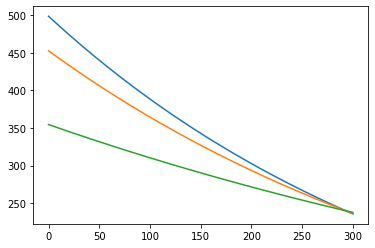

In [90]:
temp = np.linspace(0, 300, 300)
tao_0 = tc_.tao0_deduce(240*1e6, 293, 1e4, 1e-4)

ys_temp1, ys_temp2, ys_temp3 = tc_.tao_list(
    tao0=tao_0, temp=temp, 
    epsi_0=1e4, epsi_=1e-4
)

plt.plot(temp, ys_temp1*1e-6)
plt.plot(temp, ys_temp2*1e-6)
plt.plot(temp, ys_temp3*1e-6)

In [27]:
#*Varvenne model for yield strength's temperature dependence
b = 1.380649e-23 # m2 -> pm2
def taoT(t0, dE, t):
    return t0*np.exp(-1/0.51*b*t/dE*math.log(1e7))

taoT(tao0_4527-60, dE1_4527, 293)
taoT(tao0_4525-60, dE1_4525, 293)
taoT(tao0_3333, dE1_3333, 293)
#* if removing the sigma_0, values are close to reference data.

311.2504473873934

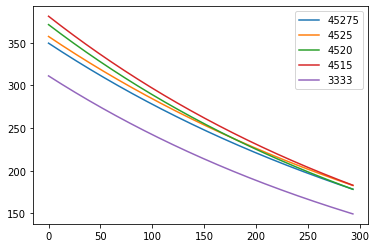

In [44]:
b = 1.380649e-23 # m2 -> pm2
def taoT(t0, dE, t):
    return t0*np.exp(-1/0.51*b*t/dE*math.log(1e7))

x_tc = np.linspace(0, 293, 10000)
tao_t_tc_4527 = taoT(tao0_4527, dE1_4527*1e6, x_tc)
tao_t_tc_4525 = taoT(tao0_4525, dE1_4525*1e6, x_tc)
tao_t_tc_4520 = taoT(tao0_4520, dE1_4520*1e6, x_tc)
tao_t_tc_4515 = taoT(tao0_4515, dE1_4515*1e6, x_tc)
tao_t_tc_3333 = taoT(tao0_3333, dE1_3333*1e6, x_tc)

plt.plot(x_tc, tao_t_tc_4527, label='45275')
plt.plot(x_tc, tao_t_tc_4525, label='4525')
plt.plot(x_tc, tao_t_tc_4520, label='4520')
plt.plot(x_tc, tao_t_tc_4515, label='4515')
plt.plot(x_tc, tao_t_tc_3333, label='3333')

legend = plt.legend()

# x_va = np.linspace(0, 293, 10000)
# tao_t_va = taoT(tao0_var, dE2, x_va)

# plt.plot(x_va, tao_t_va)